## Definitions & Imports

In [3]:
from functools import partial
from importlib import reload
import time
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, Math,Markdown

In [4]:
## Custom functions
import FermionSystem as fst
import KitaevTools as kt

## Additional Functions

In [6]:
%load_ext cython

In [7]:
%%cython 
## For speed, using cython here to define the hamiltonian function utilised
## by the sparse solver. 
## Should ideally be placed inside the FermionSystem file but did not yet figure out
## how to generate the c code (platform independently) inside the .py file

## TO DO: find out how to use this when the values are complex 

import numpy as np
cimport numpy as cnp

def hamiltonian_matvec(
    cnp.ndarray[double complex, ndim=1] x,
    cnp.ndarray[int, ndim=1] rows,
    cnp.ndarray[int, ndim=1] cols,
    cnp.ndarray[double complex, ndim=1] vals
):
    cdef int r, c, i
    cdef double complex v
    cdef cnp.ndarray[double complex, ndim=1] result = np.zeros_like(x)
    cdef int n = rows.shape[0]

    for i in range(n):
        r = rows[i]
        c = cols[i]
        v = vals[i]
        result[r] = result[r] + v * x[c]
        result[c] = result[c] + v * x[r]
    return result

DistutilsPlatformError: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/

# Basic Functions

## States and Operators

In [36]:
## FermionSystem provides functions for acting with 'operators' on Fock states using binary operations
## where both states and operators are represented by integers.
## Requires specifying the number of fermionic sites N:
N = 4
fs = fst.FermionSystem(N)

## Each integer represents a fock state in binary, where each site covers two bits (00 = 0, 01 = down, 10 = up, 11 = up+down)
fs.vis_state(1,displ=True)
fs.vis_state(2,displ=True)
fs.vis_state(3,displ=True)
fs.vis_state(4,displ=True)
fs.vis_state(0B100,displ=True)
fs.vis_state(0B111,displ=True)
fs.vis_state(0B1111,displ=True)

## The size of the system N is only relevant for the logic related to the operators
## Integers exceeding the largest possible state still just exist, but
## an operator acting on it will only be able to act on the first N sites
fs.vis_state(2000, displ=True)

|↓,0,0,0〉

|↑,0,0,0〉

|↓↑,0,0,0〉

|0,↓,0,0〉

|0,↓,0,0〉

|↓↑,↓,0,0〉

|↓↑,↓↑,0,0〉

|0,0,↓,↓↑,↓↑,↓〉

In [37]:
## Operators are similarly represented by integers, storing the position on the fock state to act on 
## + a bit specifying if the operator is creation or annihilation. 
## The largest bit sets the purpose, such that creation operators are always larger numbers than annihilation operators (for sorting in normal order)

# operator to create a spin up in site 1:
operator = fs.operator('creation',1,'up')
display(Markdown(f'Created operator {fs.vis_oper(operator)}, represented by the number: {operator}'))

Created operator $c^{†}_{1,↑}$, represented by the number: 3

## Acting on states

In [38]:
# The action of operators on fock states is handled by 'act_oper', returning the new states and the signs
operator = fs.operator('creation',1,'up')
state = 0B111

new_state,sign = fs.act_oper(operator, np.array([state]))
display(Markdown(f'{fs.vis_oper(operator)}{fs.vis_state(state)} = {"-" if sign[0] ==-1 else ""}{fs.vis_state(new_state[0])}'))

$c^{†}_{1,↑}$|↓↑,↓,0,0〉 = -|↓↑,↓↑,0,0〉

In [40]:
# A sequence of operators is represented as a list of ints
# Applying the sequence to states uses fs.act_oper_list, which returns only states that are not destroyed by the sequence
fs = fst.FermionSystem(N=4)

oper_1 = fs.operator('creation',0,'up')
oper_2 = fs.operator('creation',1,'up')
CAR_up_up = [oper_2,oper_1]

## Here: applying the CAR operator to the list of all possible Fock states
old_states,new_states,signs = fs.act_oper_list(CAR_up_up, fs.fock_states)

## Show results of the operation
display(Markdown(f"Non-zero terms for operator {fs.vis_oper_list(CAR_up_up,displ=False)}"))
for state,new_state,parity in zip(old_states,new_states,signs):
    if parity == 1:
        display(Markdown(f"{fs.vis_oper_list(CAR_up_up)}{fs.vis_state(state)} = {fs.vis_state(new_state)}"))
    else:
        display(Markdown(f"{fs.vis_oper_list(CAR_up_up)}{fs.vis_state(state)} = -{fs.vis_state(new_state)}"))

Non-zero terms for operator $c^{†}_{0,↑}$$c^{†}_{1,↑}$

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,0,0〉 = |↑,↑,0,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,0,0〉 = |↓↑,↑,0,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,0,0〉 = -|↑,↓↑,0,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,0,0〉 = -|↓↑,↓↑,0,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓,0〉 = |↑,↑,↓,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓,0〉 = |↓↑,↑,↓,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓,0〉 = -|↑,↓↑,↓,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓,0〉 = -|↓↑,↓↑,↓,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↑,0〉 = |↑,↑,↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↑,0〉 = |↓↑,↑,↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↑,0〉 = -|↑,↓↑,↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↑,0〉 = -|↓↑,↓↑,↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓↑,0〉 = |↑,↑,↓↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓↑,0〉 = |↓↑,↑,↓↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓↑,0〉 = -|↑,↓↑,↓↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓↑,0〉 = -|↓↑,↓↑,↓↑,0〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,0,↓〉 = |↑,↑,0,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,0,↓〉 = |↓↑,↑,0,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,0,↓〉 = -|↑,↓↑,0,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,0,↓〉 = -|↓↑,↓↑,0,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓,↓〉 = |↑,↑,↓,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓,↓〉 = |↓↑,↑,↓,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓,↓〉 = -|↑,↓↑,↓,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓,↓〉 = -|↓↑,↓↑,↓,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↑,↓〉 = |↑,↑,↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↑,↓〉 = |↓↑,↑,↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↑,↓〉 = -|↑,↓↑,↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↑,↓〉 = -|↓↑,↓↑,↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓↑,↓〉 = |↑,↑,↓↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓↑,↓〉 = |↓↑,↑,↓↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓↑,↓〉 = -|↑,↓↑,↓↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓↑,↓〉 = -|↓↑,↓↑,↓↑,↓〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,0,↑〉 = |↑,↑,0,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,0,↑〉 = |↓↑,↑,0,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,0,↑〉 = -|↑,↓↑,0,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,0,↑〉 = -|↓↑,↓↑,0,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓,↑〉 = |↑,↑,↓,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓,↑〉 = |↓↑,↑,↓,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓,↑〉 = -|↑,↓↑,↓,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓,↑〉 = -|↓↑,↓↑,↓,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↑,↑〉 = |↑,↑,↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↑,↑〉 = |↓↑,↑,↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↑,↑〉 = -|↑,↓↑,↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↑,↑〉 = -|↓↑,↓↑,↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓↑,↑〉 = |↑,↑,↓↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓↑,↑〉 = |↓↑,↑,↓↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓↑,↑〉 = -|↑,↓↑,↓↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓↑,↑〉 = -|↓↑,↓↑,↓↑,↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,0,↓↑〉 = |↑,↑,0,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,0,↓↑〉 = |↓↑,↑,0,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,0,↓↑〉 = -|↑,↓↑,0,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,0,↓↑〉 = -|↓↑,↓↑,0,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓,↓↑〉 = |↑,↑,↓,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓,↓↑〉 = |↓↑,↑,↓,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓,↓↑〉 = -|↑,↓↑,↓,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓,↓↑〉 = -|↓↑,↓↑,↓,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↑,↓↑〉 = |↑,↑,↑,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↑,↓↑〉 = |↓↑,↑,↑,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↑,↓↑〉 = -|↑,↓↑,↑,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↑,↓↑〉 = -|↓↑,↓↑,↑,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,0,↓↑,↓↑〉 = |↑,↑,↓↑,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,0,↓↑,↓↑〉 = |↓↑,↑,↓↑,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|0,↓,↓↑,↓↑〉 = -|↑,↓↑,↓↑,↓↑〉

$c^{†}_{0,↑}$$c^{†}_{1,↑}$|↓,↓,↓↑,↓↑〉 = -|↓↑,↓↑,↓↑,↓↑〉

## Convert between states/operators

In [41]:
## Convert from a state to the creation operators

fs = fst.FermionSystem(N=4)
state = 0B11011001

opers = fs.state_to_oper_list(state)
display(Markdown(f'{fs.vis_state(state)} = {fs.vis_oper_list(opers)}{fs.vis_state(0)}'))

|↓,↑,↓,↓↑〉 = $c^{†}_{0,↓}$$c^{†}_{1,↑}$$c^{†}_{2,↓}$$c^{†}_{3,↓}$$c^{†}_{3,↑}$|0,0,0,0〉

In [42]:
## Given two states, return the operator and sign to convert the first state into the second state
## TO DO: fix sign issue (boils down to fixing bug in normal ordering for same-site operators)
fs = fst.FermionSystem(N=4)

state_1 = 0B101011
state_2 = 0B1101

oper,sign = fs.state_to_state(state_1,state_2)
display(Markdown(f'{fs.vis_state(state_2)} = {"-" if sign < 0  else ""}{fs.vis_oper_list(oper)}{fs.vis_state(state_1)}'))

|↓,↓↑,0,0〉 = $c^{†}_{1,↓}$$c_{0,↑}$$c_{2,↑}$|↓↑,↑,↑,0〉

## Normal Ordering

In [43]:
## Normal ordering of the states requires sorting the list of operators (integers) in size 
## This is now done with a bubble sort, which straightforwardly allows tracking the number of swaps

fs = fst.FermionSystem(N=4)

## Example of an non-ordered list of operators:
oper_list = [fs.operator('creation',1,'up'), fs.operator('annihilation',0,'down'),fs.operator('creation',1,'down'), fs.operator('creation',2,'down')]
display(Markdown(f'Original sequence: {fs.vis_oper_list(oper_list)} ({oper_list})'))

## Retrieving the list in order + the sign
normal_ordered,sign = fs.normal_order(oper_list)
display(Markdown(f'Normal order: {"-" if sign < 1 else ""}{fs.vis_oper_list(normal_ordered)} ({normal_ordered})'))

Original sequence: $c^{†}_{2,↓}$$c^{†}_{1,↓}$$c_{0,↓}$$c^{†}_{1,↑}$ ([3, 8, 2, 4])

Normal order: -$c^{†}_{1,↓}$$c^{†}_{1,↑}$$c^{†}_{2,↓}$$c_{0,↓}$ ([8, 4, 3, 2])

## Bra-Kets

In [44]:
## <phi|(operators)|phi> matrices can be calculated with bra_oper_ket function
## Where (phi) is an array storign the weights of the system eigenvectors 

fs = fst.FermionSystem(N=4)
states = fs.fock_states

## Phi are the weights of the eigenstates. For this example just the I matrix
phi = np.zeros((len(states),len(states)))
np.fill_diagonal(phi,1)

## Make an operator list. This simple example returns a matrix representing which Fock states are connected by CAR_down_down
CAR_down_down = [fs.operator('creation',0,'down'),fs.operator('creation',1,'down')]
operators = [fs.normal_order(CAR_down_down)[0]]

## Calculate matrix
M = fs.bra_oper_ket(states, phi, operators)

## Visualize outcome
non_zero_terms = np.where(M!=0)
for row,col in zip(non_zero_terms[0], non_zero_terms[1]):
    display(Markdown(f'{fs.vis_oper_list(CAR_down_down)}{fs.vis_state(col)} = {"-" if M[row][col]<0 else ""}{fs.vis_state(row)}'))



$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,0,0〉 = |↓,↓,0,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,0,0〉 = -|↓↑,↓,0,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,0,0〉 = |↓,↓↑,0,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,0,0〉 = -|↓↑,↓↑,0,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓,0〉 = |↓,↓,↓,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓,0〉 = -|↓↑,↓,↓,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓,0〉 = |↓,↓↑,↓,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓,0〉 = -|↓↑,↓↑,↓,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↑,0〉 = |↓,↓,↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↑,0〉 = -|↓↑,↓,↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↑,0〉 = |↓,↓↑,↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↑,0〉 = -|↓↑,↓↑,↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓↑,0〉 = |↓,↓,↓↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓↑,0〉 = -|↓↑,↓,↓↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓↑,0〉 = |↓,↓↑,↓↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓↑,0〉 = -|↓↑,↓↑,↓↑,0〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,0,↓〉 = |↓,↓,0,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,0,↓〉 = -|↓↑,↓,0,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,0,↓〉 = |↓,↓↑,0,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,0,↓〉 = -|↓↑,↓↑,0,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓,↓〉 = |↓,↓,↓,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓,↓〉 = -|↓↑,↓,↓,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓,↓〉 = |↓,↓↑,↓,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓,↓〉 = -|↓↑,↓↑,↓,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↑,↓〉 = |↓,↓,↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↑,↓〉 = -|↓↑,↓,↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↑,↓〉 = |↓,↓↑,↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↑,↓〉 = -|↓↑,↓↑,↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓↑,↓〉 = |↓,↓,↓↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓↑,↓〉 = -|↓↑,↓,↓↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓↑,↓〉 = |↓,↓↑,↓↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓↑,↓〉 = -|↓↑,↓↑,↓↑,↓〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,0,↑〉 = |↓,↓,0,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,0,↑〉 = -|↓↑,↓,0,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,0,↑〉 = |↓,↓↑,0,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,0,↑〉 = -|↓↑,↓↑,0,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓,↑〉 = |↓,↓,↓,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓,↑〉 = -|↓↑,↓,↓,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓,↑〉 = |↓,↓↑,↓,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓,↑〉 = -|↓↑,↓↑,↓,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↑,↑〉 = |↓,↓,↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↑,↑〉 = -|↓↑,↓,↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↑,↑〉 = |↓,↓↑,↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↑,↑〉 = -|↓↑,↓↑,↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓↑,↑〉 = |↓,↓,↓↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓↑,↑〉 = -|↓↑,↓,↓↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓↑,↑〉 = |↓,↓↑,↓↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓↑,↑〉 = -|↓↑,↓↑,↓↑,↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,0,↓↑〉 = |↓,↓,0,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,0,↓↑〉 = -|↓↑,↓,0,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,0,↓↑〉 = |↓,↓↑,0,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,0,↓↑〉 = -|↓↑,↓↑,0,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓,↓↑〉 = |↓,↓,↓,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓,↓↑〉 = -|↓↑,↓,↓,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓,↓↑〉 = |↓,↓↑,↓,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓,↓↑〉 = -|↓↑,↓↑,↓,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↑,↓↑〉 = |↓,↓,↑,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↑,↓↑〉 = -|↓↑,↓,↑,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↑,↓↑〉 = |↓,↓↑,↑,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↑,↓↑〉 = -|↓↑,↓↑,↑,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,0,↓↑,↓↑〉 = |↓,↓,↓↑,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,0,↓↑,↓↑〉 = -|↓↑,↓,↓↑,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|0,↑,↓↑,↓↑〉 = |↓,↓↑,↓↑,↓↑〉

$c^{†}_{0,↓}$$c^{†}_{1,↓}$|↑,↑,↓↑,↓↑〉 = -|↓↑,↓↑,↓↑,↓↑〉

# Example: Effective Kitaev Model

## Constructing and solving system

In [45]:
## Generating a Hamiltonian requires creating the list of operator-lists
## The function 'generate_kitaev_hamiltonian' generates all nearest neighbour interactions + chemical potentials + Us
N=4
fs = fst.FermionSystem(N,store_fock_states=False)
hamiltonian = kt.make_kitaev_hamiltonian(fs)
operator_list = hamiltonian[0]
display(Markdown(f'Hamiltonian representation: {operator_list}'))

## A mapping is needed to map  operators -> values and readable symbols, such that the H_params can be entered as readable
## A function 'map_H_params' maps both the operator lists and the H_params below to the same string representation.
H_params = {
    'd_dd': [0]*(N-1),'d_uu': [0]*(N-1),'d_ud': [20]*(N-1),'d_du': [20]*(N-1),
    't_dd': [20]*(N-1),'t_uu': [20]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}
H_vals,H_symbols,H_types = kt.map_H_params_kitaev(fs,H_params)

str = 'H = '
for oper in operator_list:
    str += f'{H_symbols[fs.oper_list_to_str(oper)]}'+ f'{fs.vis_oper_list(oper)}' + ' + '
display(Markdown(str[:-2]))

Hamiltonian representation: [[9, 3], [11, 5], [13, 7], [3, 1], [5, 3], [7, 5], [9, 2], [11, 4], [13, 6], [2, 1], [4, 3], [6, 5], [8, 3], [10, 5], [12, 7], [3, 0], [5, 2], [7, 4], [8, 2], [10, 4], [12, 6], [2, 0], [4, 2], [6, 4], [9, 1], [11, 3], [13, 5], [15, 7], [8, 0], [10, 2], [12, 4], [14, 6], [9, 8, 1, 0], [11, 10, 3, 2], [13, 12, 5, 4], [15, 14, 7, 6]]

H = $t_{↑↑}^{0}$$c^{†}_{1,↑}$$c_{0,↑}$ + $t_{↑↑}^{1}$$c^{†}_{2,↑}$$c_{1,↑}$ + $t_{↑↑}^{2}$$c^{†}_{3,↑}$$c_{2,↑}$ + $Δ_{↑↑}^{0}$$c^{†}_{0,↑}$$c^{†}_{1,↑}$ + $Δ_{↑↑}^{1}$$c^{†}_{1,↑}$$c^{†}_{2,↑}$ + $Δ_{↑↑}^{2}$$c^{†}_{2,↑}$$c^{†}_{3,↑}$ + $t_{↑↓}^{0}$$c^{†}_{1,↓}$$c_{0,↑}$ + $t_{↑↓}^{1}$$c^{†}_{2,↓}$$c_{1,↑}$ + $t_{↑↓}^{2}$$c^{†}_{3,↓}$$c_{2,↑}$ + $Δ_{↑↓}^{0}$$c^{†}_{0,↑}$$c^{†}_{1,↓}$ + $Δ_{↑↓}^{1}$$c^{†}_{1,↑}$$c^{†}_{2,↓}$ + $Δ_{↑↓}^{2}$$c^{†}_{2,↑}$$c^{†}_{3,↓}$ + $t_{↓↑}^{0}$$c^{†}_{1,↑}$$c_{0,↓}$ + $t_{↓↑}^{1}$$c^{†}_{2,↑}$$c_{1,↓}$ + $t_{↓↑}^{2}$$c^{†}_{3,↑}$$c_{2,↓}$ + $Δ_{↓↑}^{0}$$c^{†}_{0,↓}$$c^{†}_{1,↑}$ + $Δ_{↓↑}^{1}$$c^{†}_{1,↓}$$c^{†}_{2,↑}$ + $Δ_{↓↑}^{2}$$c^{†}_{2,↓}$$c^{†}_{3,↑}$ + $t_{↓↓}^{0}$$c^{†}_{1,↓}$$c_{0,↓}$ + $t_{↓↓}^{1}$$c^{†}_{2,↓}$$c_{1,↓}$ + $t_{↓↓}^{2}$$c^{†}_{3,↓}$$c_{2,↓}$ + $Δ_{↓↓}^{0}$$c^{†}_{0,↓}$$c^{†}_{1,↓}$ + $Δ_{↓↓}^{1}$$c^{†}_{1,↓}$$c^{†}_{2,↓}$ + $Δ_{↓↓}^{2}$$c^{†}_{2,↓}$$c^{†}_{3,↓}$ + $μ_{↑,0}$$c^{†}_{0,↑}$$c_{0,↑}$ + $μ_{↑,1}$$c^{†}_{1,↑}$$c_{1,↑}$ + $μ_{↑,2}$$c^{†}_{2,↑}$$c_{2,↑}$ + $μ_{↑,3}$$c^{†}_{3,↑}$$c_{3,↑}$ + $μ_{↓,0}$$c^{†}_{0,↓}$$c_{0,↓}$ + $μ_{↓,1}$$c^{†}_{1,↓}$$c_{1,↓}$ + $μ_{↓,2}$$c^{†}_{2,↓}$$c_{2,↓}$ + $μ_{↓,3}$$c^{†}_{3,↓}$$c_{3,↓}$ + $U_{0}$$c^{†}_{0,↓}$$c^{†}_{0,↑}$$c_{0,↓}$$c_{0,↑}$ + $U_{1}$$c^{†}_{1,↓}$$c^{†}_{1,↑}$$c_{1,↓}$$c_{1,↑}$ + $U_{2}$$c^{†}_{2,↓}$$c^{†}_{2,↑}$$c_{2,↓}$$c_{2,↑}$ + $U_{3}$$c^{†}_{3,↓}$$c^{†}_{3,↑}$$c_{3,↓}$$c_{3,↑}$ 

In [ ]:
# An additional class (ParitySystem) is relevant for cases where a division of the fock states 
# into odd and even parity sectors is desired (i.e.: the Kitaev chain)
N=3

## Dictionary with all relevant parameters
## Parameter names used here are arbitrary, a function is required to link them to the correct 'operators' ('map_H_params_Kitaev' in this case)
H_params = {
    'd_dd': [0]*(N-1),'d_uu': [0]*(N-1),'d_ud': [20]*(N-1),'d_du': [20]*(N-1),
    't_dd': [20]*(N-1),'t_uu': [20]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}
fs = fst.FermionSystem(N)

## Generate a list of all relevant operators for the Kitaev chain (with interactions)
## This is just a list with lists of integers representing the operator sequences
generate_kitaev_hamiltonian = partial(kt.make_kitaev_hamiltonian,fs)

## Links operators to understandable parameter names
generate_mapping = partial(kt.map_H_params_kitaev,fs,H_params)

## Create a ParitySystem (builds on FermionSystem): seperates the fock states into odd and even parity states 
## and applies the provided Hamiltonian to calculate non-zero terms for later use
chain = fst.ParitySystem(N = N, H_generator=generate_kitaev_hamiltonian,H_mapping = generate_mapping, Ez_inf = True, U_inf=True)
chain.gather_H()
## Once chain is constructed, can use solve_system to get eigenvalues and eigenvector
## Two methods are included:
## 'linalg' -> uses numpy's linalg.eigh, requires constructing the matrix
## 'sparse' -> uses scipy's LinearOperator class, does not require explicitly filling a matrix
##             returns the lowest N eigenvalues and eigenvectors (set by 'n_values')
##             The method is faster for N>4, if only a small number of eigenvalues are needed
display(Markdown("**Method: Sparse**"))
print("Not available :(")
#E_odd,E_even, phi_odd,phi_even = chain.solve_system(method='sparse', n_values=1)
#print(f"Odd ground state energy: {np.round(E_odd[0],3)}")
#print(f"Odd ground state: {chain.vis_state_list(chain.odd_states,phi_odd[0])}\n")
#print(f"Even ground state energy: {np.round(E_even[0],3)}")
#print(f"Even ground state: {chain.vis_state_list(chain.even_states,phi_even[0])}\n")
#print("________________")
display(Markdown("**Method: Linalg**"))
E_odd,E_even, phi_odd,phi_even = chain.solve_system(method='linalg')
print(f"Odd ground state energy: {np.round(E_odd[0],3)}")
print(f"Odd ground state: {chain.vis_state_list(chain.odd_states,phi_odd[0])}\n")
print(f"Even ground state energy: {np.round(E_even[0],3)}")
print(f"Even ground state: {chain.vis_state_list(chain.even_states,phi_even[0])}\n")

**Method: Sparse**

Not available :(


**Method: Linalg**

Odd ground state energy: -28.284
Odd ground state: +0.5|↓,0,0〉-0.707|0,↓,0〉+0.5|0,0,↓〉

Even ground state energy: -28.284
Even ground state: +0.5|↓,↓,0〉-0.707|↓,0,↓〉+0.5|0,↓,↓〉



In [17]:
## To show all eigenstates and solutions:
chain = kt.make_kitaev_chain(2, H_params, Ez_inf = False, U_inf=True) # shortcut for the Kitaev chain construction
chain.eigenstates(only_ground_states=False,only_energies=False)

(ground) (even)      E = -28.28     |φ〉= +0.707|0,0〉+0.5|↑,↓〉-0.5|↓,↑〉
(excited) (odd)      E = -20.00     |φ〉= -0.707|↓,0〉+0.707|0,↓〉
(excited) (odd)      E = -20.00     |φ〉= +0.707|↑,0〉-0.707|0,↑〉
(excited) (even)     E = -0.00      |φ〉= +0.707|↑,↓〉+0.707|↓,↑〉
(excited) (even)     E = 0.00       |φ〉= +1.0|↓,↓〉
(excited) (even)     E = 0.00       |φ〉= +1.0|↑,↑〉
(excited) (odd)      E = 20.00      |φ〉= +0.707|↑,0〉+0.707|0,↑〉
(excited) (odd)      E = 20.00      |φ〉= -0.707|↓,0〉-0.707|0,↓〉
(excited) (even)     E = 28.28      |φ〉= -0.707|0,0〉+0.5|↑,↓〉-0.5|↓,↑〉


Basis: |0,0〉, |↓,↓〉, |↑,↓〉, |↓,↑〉, |↑,↑〉


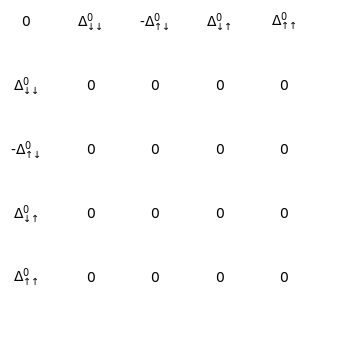

In [18]:
## For small Hamiltonians and debugging: print a symbolic Hamiltonian (only shows non-diagonal terms)

chain = kt.make_kitaev_chain(2, H_params, Ez_inf = False, U_inf=True) # shortcut for the Kitaev chain construction
#chain.eigenstates(only_ground_states=False,only_energies=False)
chain.show_hamiltonian(parity = 'even')

Updated to have value of 5 for mu_0_down:
Basis: |0,0〉, |↓,↓〉, |↑,↓〉, |↓,↑〉, |↑,↑〉


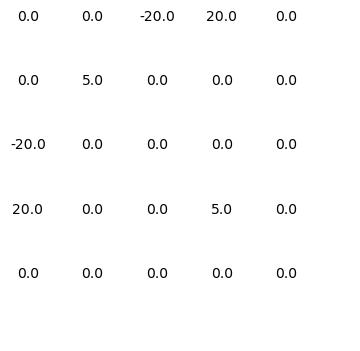

In [19]:
## The hamiltonian parameters can be updated without having to redo the entire matrix
chain = kt.make_kitaev_chain(2, H_params, Ez_inf = False, U_inf=True, make_arrays=True) # shortcut for the Kitaev chain construction
chain.update_H_param_list(['mu_d_0'], 5, update_matrix=True)
print("Updated to have value of 5 for mu_0_down:")
chain.show_hamiltonian(parity = 'even', numeric=True)


## Energy Spectrum 

100%|██████████| 100/100 [00:00<00:00, 157.72it/s]


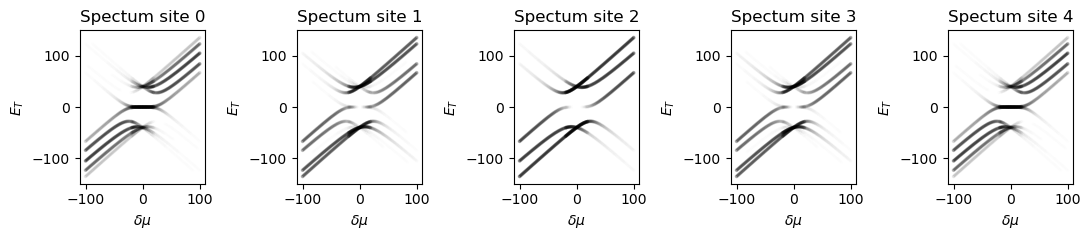

In [20]:
## To calculate a simplified energy spectrum (for comparing to finite bias conductace measurements)
## the function'energy_spectrum' extracts transitions and probablities for transitions 
## between even and odd ground states to excited states. 
## This gives a simplified representation, but provides speed over solving the rate equation (below)

N = 5

## Create Figure
fig, axs = plt.subplots(ncols = N, figsize = (N*2.2, 2.5))
for ax in axs:
    ax.grid(False)
    ax.set_ylim ([-150,150])
    ax.set_xlabel('$\\delta \\mu$')
    ax.set_ylabel('$E_{T}$')


## Set parameters
H_params = {
    'd_dd': [20]*(N-1),'d_uu': [20]*(N-1),'d_ud': [20]*(N-1),'d_du': [20]*(N-1),
    't_dd': [20]*(N-1),'t_uu': [20]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}

## Create chain
chain = kt.make_kitaev_chain(N,H_params, Ez_inf=True,U_inf=True, make_arrays=True)

## Range and parameters to vary 
mu_range = np.linspace(-100,100,100)
vary_params =  [f'mu_d_{i}' for i in range(chain.N) ] + [f'mu_u_{i}' for i in range(chain.N)] # All mu_down parameters int he chain

## PLot energy spectrum for all sites
timed = 0
kt.energy_spectrum(chain, vary_params, mu_range, range(N), fig, axs, plot=True)
plt.tight_layout()

## Conductance from rate equation

In [22]:
lead_params = {
    'gammas': [0.001],
    'kBT':0.002,
    'dV':0.001
}

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


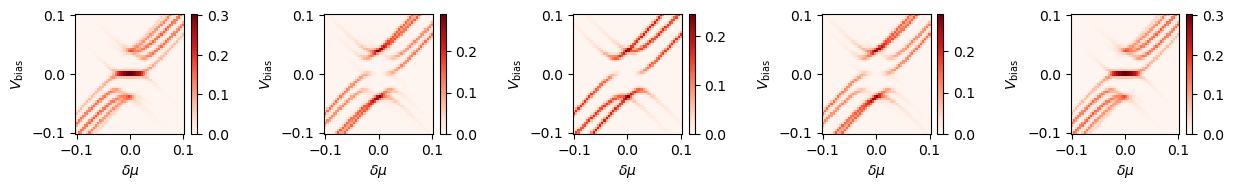

In [23]:
N = 5
H_params = {
    'd_dd': [20e-3]*(N-1),'d_uu': [20e-3]*(N-1),'d_ud': [0]*(N-1),'d_du': [0]*(N-1),
    't_dd': [20e-3]*(N-1),'t_uu': [20e-3]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}
chain = kt.make_kitaev_chain(N, H_params, Ez_inf = True, U_inf=True, make_arrays=True) # shortcut for the Kitaev chain construction

vary_params = [f'mu_d_{i}' for i in range(N)] + [f'mu_u_{i}' for i in range(N)]
param_range = np.linspace(-100e-3,100e-3,50)
bias_range = np.linspace(-100e-3,100e-3,50)

## When getting conductance, can truncate the number of eigenvectors to pass to the rate equation (given by n_values)
lead_params['gammas'] = [0.001]*N
Gs_dataset = kt.conductance_spectrum(chain, vary_params, param_range,bias_range, sites = [i for i in range(N)], lead_params = lead_params, plot=True, method='linalg', n_values = 30)


100%|██████████| 80/80 [00:04<00:00, 19.04it/s]


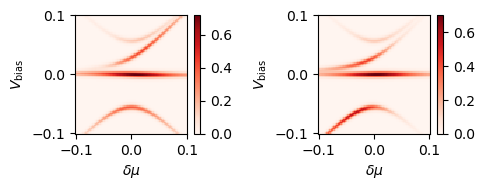

In [24]:
N = 2
H_params = {
    'd_dd': [0e-3]*(N-1),'d_uu': [0e-3]*(N-1),'d_ud': [20e-3]*(N-1),'d_du': [20e-3]*(N-1),
    't_dd': [np.sqrt(2)*20e-3]*(N-1),'t_uu': [np.sqrt(2)*20e-3]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}

chain = kt.make_kitaev_chain(N, H_params, Ez_inf = False, U_inf=True, make_arrays=True) # shortcut for the Kitaev chain construction

vary_params = [f'mu_d_1','mu_u_1']
param_range = np.linspace(-100e-3,100e-3,80)
bias_range = np.linspace(-100e-3,100e-3,80)

## When getting conductance, can truncate the number of eigenvectors to pass to the rate equation (given by n_values)
lead_params['gammas'] = [0.001]*N
Gs_dataset = kt.conductance_spectrum(chain, vary_params, param_range,bias_range, sites = [i for i in range(N)], lead_params =  lead_params, plot=True, method='linalg', n_values = 50)


100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:10<00:00,  7.58it/s]


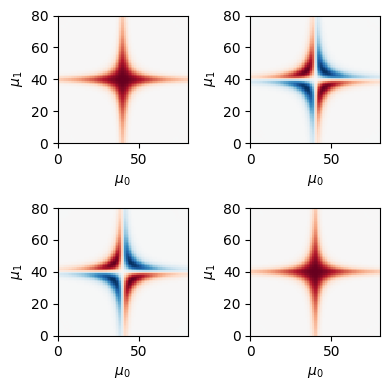

In [22]:
fig,axs = plt.subplots(ncols=2,nrows=2, figsize = (4,4))
for ax_row in axs:
    for ax in ax_row:
        ax.set_xlabel('$\\mu_0$')
        ax.set_ylabel('$\\mu_1$')

## Set up a Kitaev chain
N=2
H_params = {
    'd_dd': [30e-3]*(N-1),'d_uu': [30e-3]*(N-1),'d_ud': [0]*(N-1),'d_du': [0]*(N-1),
    't_dd': [30e-3]*(N-1),'t_uu': [30e-3]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}
chain = kt.make_kitaev_chain(N,H_params, Ez_inf=True,U_inf=True, make_arrays=True)

## Select parameters and ranges
x_range = np.linspace(-100e-3,100e-3, 80)
y_range = np.linspace(-100e-3,100e-3, 80)

## Instruct to vary mu_0 vs mu_1
vary_x = ['mu_d_0']
vary_y = ['mu_d_1']
sites = [0,1]

lead_params['gammas'] = [0.001]*N
results = kt.charge_stability_diagram(chain,vary_x,x_range, vary_y,y_range,sites=sites,lead_params=lead_params,method='linalg')
count = 0
for i in range(len(sites)):
    for j in range(len(sites)):
        if i != j:
            axs[i][j].pcolormesh(results[f'G_{sites[i]}{sites[j]}'], cmap='RdBu_r')
        else:
            vmax = np.max(results[f'G_{sites[i]}{sites[j]}'])
            axs[i][j].pcolormesh(results[f'G_{sites[i]}{sites[j]}'], cmap='RdBu_r',vmin=-vmax,vmax=vmax)

plt.tight_layout()


## Odd-Even Phase Space

100%|██████████| 150/150 [00:06<00:00, 23.56it/s]


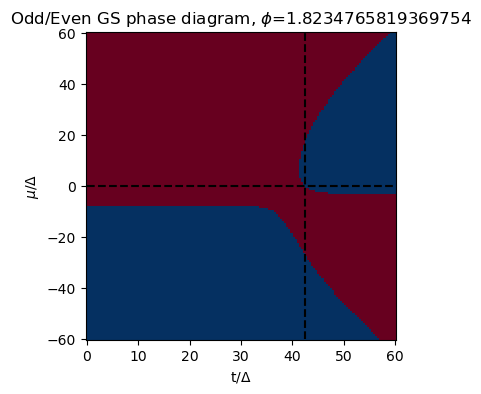

In [25]:
N=3
phi = np.arccos(-1/4)
delta= 30

H_params = {
    'd_dd': [0]*(N-1),'d_uu': [0]*(N-1),'d_ud': [delta,delta*(np.exp(-1j*phi))],'d_du': [delta,delta*np.exp(-1j*phi)],
    't_dd': [40e-3]*(N-1),'t_uu': [40e-3]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}
chain = kt.make_kitaev_chain(N,H_params, Ez_inf=False,U_inf=True, make_arrays=True)
## Select parameters and ranges
mu_range = np.array(np.linspace(-60,60,150))
t_range = np.linspace(0,2*delta, 150)

## Instruct to vary all mu parameters and all t parameters
vary_mu = [f'mu_d_{i}' for i in range(N)] + [f'mu_u_{i}' for i in range(N)]
vary_t = [f't_uu_{i}' for i in range(N-1)] + [f't_dd_{i}' for i in range(N-1)] 

## Calculate energy differences
results = np.array(kt.phase_space(chain,vary_t,t_range, vary_mu, mu_range,T=1,disable=False)[0])

res_array = np.zeros(np.shape(results))
threshhold = 0.001
pos = np.where(results > threshhold)
neg = np.where(results < -threshhold)
res_array[pos]=1
res_array[neg]=-1
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,4))
ax.pcolormesh(t_range,mu_range,res_array,cmap='RdBu_r',shading='auto')
ax.set_title('Odd/Even GS phase diagram, $\\phi$='+f'{phi}')
ax.set_xlabel('t/$\\Delta$')
ax.set_ylabel('$\\mu$/$\\Delta$')
ax.plot([0,60],[0,0],linestyle='dashed',color='black')
ax.plot([np.sqrt(2)*delta, np.sqrt(2)*delta],[-60,60],color='black',linestyle='dashed')

## Block Diagonalize

In [26]:
## Block diagonalize the matrix and visualize with graphs or with plt.matshow
## block_diagonalize function reorders the basis states and regenerates the hamiltonian
## If a state is nonzero but only couples to itself I.e. only shows up on the diagonal) it is removed from the basis

In [27]:
N=3
H_params = {
    'd_dd': [0]*(N-1),'d_uu': [0]*(N-1),'d_ud': [40]*(N-1),'d_du': [40]*(N-1),
    't_dd': [40]*(N-1),'t_uu': [40]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [1]*N,'Ez': [0]*N,'U': [0]*N,
}
times=[]

chain = kt.make_kitaev_chain(N,H_params, Ez_inf=False,U_inf=True, make_arrays=True)


Obtained 3 Even blocks


1: |0,0,0〉 |↑,↓,0〉 |↓,↑,0〉 |↑,0,↓〉 |0,↑,↓〉 |↓,0,↑〉 |0,↓,↑〉 

2: |↑,0,↑〉 |0,↑,↑〉 |↑,↑,0〉 

3: |↓,↓,0〉 |↓,0,↓〉 |0,↓,↓〉 

Obtained 4 Odd blocks


1: |↑,0,0〉 |0,↑,0〉 |↑,↑,↓〉 |0,0,↑〉 |↑,↓,↑〉 |↓,↑,↑〉 

2: |↓,0,0〉 |0,↓,0〉 |0,0,↓〉 |↑,↓,↓〉 |↓,↑,↓〉 |↓,↓,↑〉 

3: |↑,↑,↑〉 

4: |↓,↓,↓〉 

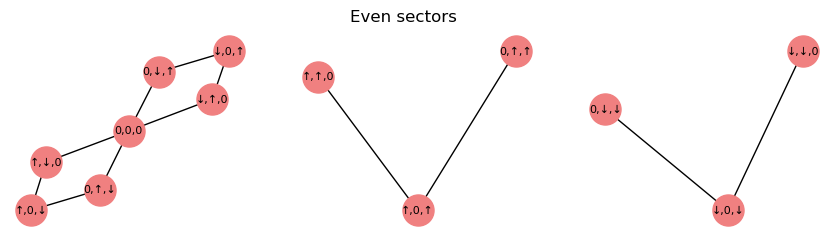

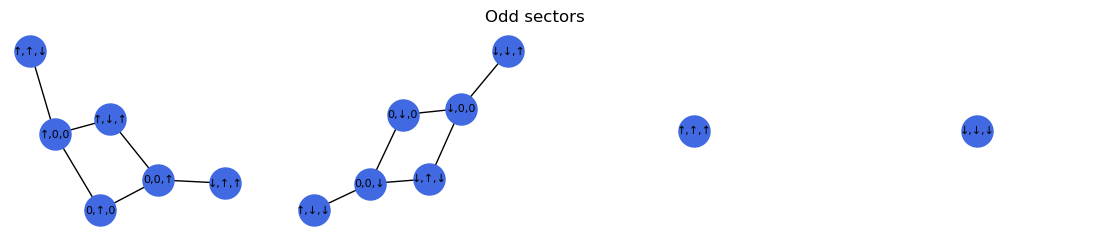

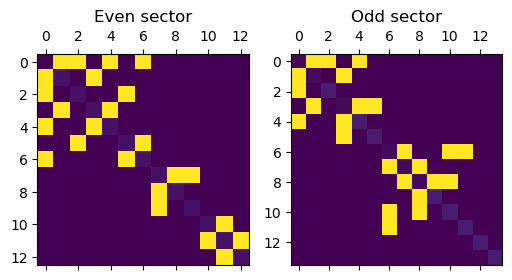

In [28]:
blocks = chain.block_diagonalize(print_result=True, graph=True)